In [125]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


import torch
import torch.nn as nn
import torch.nn.functional as F

In [126]:
IMG_SIZE = (64,64)
BATCH_SIZE = 32
DATA_DIR = "../data"

train_ds = keras.preprocessing.image_dataset_from_directory(
    DATA_DIR + "/train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

val_ds = keras.preprocessing.image_dataset_from_directory(
    DATA_DIR + "/val",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

test_ds = keras.preprocessing.image_dataset_from_directory(
    DATA_DIR + "/test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

Found 474 files belonging to 2 classes.


Found 135 files belonging to 2 classes.
Found 70 files belonging to 2 classes.


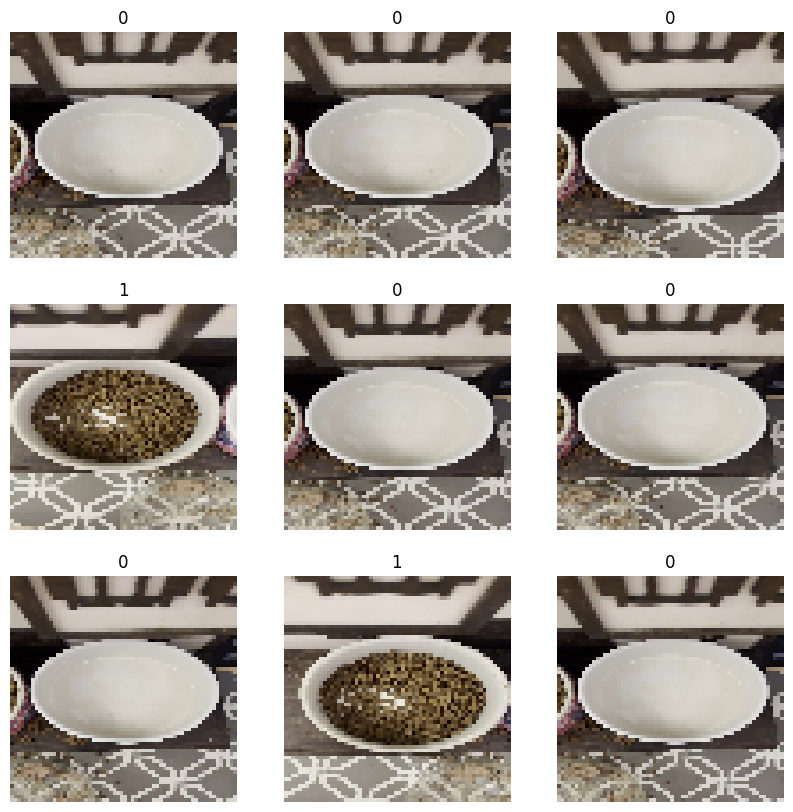

In [127]:
images, labels = next(iter(train_ds))

plt.figure(figsize=(10, 10))

for i in range(9):  
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(str(labels[i].numpy()))
    plt.axis("off")

plt.show()

In [128]:
IMG_SIZE = 32

model = keras.Sequential([
    keras.layers.Rescaling(1/255.0, input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    keras.layers.Conv2D(8, 3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(8, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])


model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)


C:\Users\silva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\layers\preprocessing\data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [129]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.5359 - loss: 0.6900 - val_accuracy: 0.5333 - val_loss: 0.6814
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5359 - loss: 0.6727 - val_accuracy: 0.5333 - val_loss: 0.6598
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5696 - loss: 0.6425 - val_accuracy: 0.6889 - val_loss: 0.6143
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8418 - loss: 0.5760 - val_accuracy: 0.6000 - val_loss: 0.5307
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9198 - loss: 0.4696 - val_accuracy: 1.0000 - val_loss: 0.4036
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9557 - loss: 0.3542 - val_accuracy: 1.0000 - val_loss: 0.2815
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.2371 - val_accuracy: 1.0000 - val_loss: 0.1851
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 0.1574 - val_accuracy: 1.0000 - v

In [130]:
model.evaluate(test_ds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0582


[0.05822934955358505, 1.0]

In [131]:
model.export("saved_model")

# Convert to .tflite (float)
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
tflite_model = converter.convert()

with open("catbowl.tflite", "wb") as f:
    f.write(tflite_model)

print("Saved catbowl.tflite")

INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor_892')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2389569600400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2389569594832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2389569590224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2389569587920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2389569595984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2389569590608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2389569586000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2389569587728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2389569586960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2389569601360: TensorSpec(shape=(), dtype=tf.resource, name=None)
Saved catbowl.tflite
